In [1]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

import numpy as np
import cv2 as cv
from cake import cake
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from scipy import signal
from scipy.spatial.transform import Rotation as R
from cluster_half_shelfs_alpha import Half_shelf_cluster
from cluster_to_edge_pixel import contour_edge
from matplotlib.colors import ListedColormap
from matplotlib.patches import Ellipse
from matplotlib.patches import Arc
from confectionery import Confectionery
from utitlity_functions import *
from scipy.spatial.transform import Rotation as R
import matplotlib as mpl
from matplotlib import cm
from particle_data_structure import ParticleDataStruct
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcdefaults()
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 11,
    'text.usetex': True,
})
import matplotlib.patches as mpatches
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal


np.random.seed(137)

In [2]:
folder_name="Gute_aufnahme_shortened"


In [3]:
data_paths=os.listdir(os.path.join("../data",folder_name))
stream_string=np.load(os.path.join("../data",folder_name,"image_paths_smooth.npy"))
objs=[x for x in data_paths if "pos_data" in x]
objs_number=np.array([int(x[9:-4]) for x in objs])
indexing=np.argsort(objs_number)
objs=[np.load(os.path.join("../data",folder_name,objs[x])) for x in indexing]
number_objs=len(objs)

koppenrath=Confectionery()


particle_structured3d_path=os.path.join("../data",folder_name,"particle_structured3d_")
particle_structured_flat_path=os.path.join("../data",folder_name,"particle_structured_flat_")

In [4]:
cut_radius=[int(np.floor(np.mean(x[:,-1])))-1 for x in objs]
structured_datas=[ParticleDataStruct(x,stream_string,c,koppenrath) for x,c in zip(objs,cut_radius)]
particle_datas_3d=[np.load(particle_structured3d_path+str(i)+".npy")for i in range(number_objs)]
particle_datas_flat=[np.load(particle_structured_flat_path+str(i)+".npy") for i in range(number_objs)]
particle_datas_flat_effective=[x.get_data_flatten_effective(c,y) for x,y,c in zip(structured_datas,particle_datas_flat,cut_radius)]

In [5]:
half_shelf_clusters=[Half_shelf_cluster(objs, stream_string, confectionery=koppenrath,cut_radius=c) for x,c in zip(objs,cut_radius)]
priors=[]
means=[]
variance=[]
labels=[]
avg_likelihood=[]
datas=[]
for i in range(number_objs):
    half_shelf_clusters[i].load_data_from_np_array(particle_datas_flat_effective[i].flatten())
    pi,l = half_shelf_clusters[i].train_gmm()
    datas.append(particle_datas_flat_effective[i].flatten())
    priors.append(pi)
    means.append(half_shelf_clusters[i].means_gmm)
    variance.append(half_shelf_clusters[i].variance)
    avg_likelihood.append(l)



In [6]:
objects_clustered=[]
for i in range(number_objs):
    label=half_shelf_clusters[i].label(particle_datas_flat_effective[i].flatten(),method="GMM")
    label=label+1
    label_flat_effective=label.reshape(particle_datas_flat_effective[i].shape)
    label_flat=structured_datas[i].data_flatten_effective_to_data_flat(cut_radius[i],label_flat_effective)
    objects_clustered.append(structured_datas[i].expand_data(label_flat).astype(int))


# selecting good image

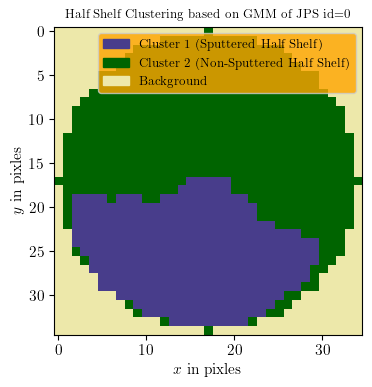

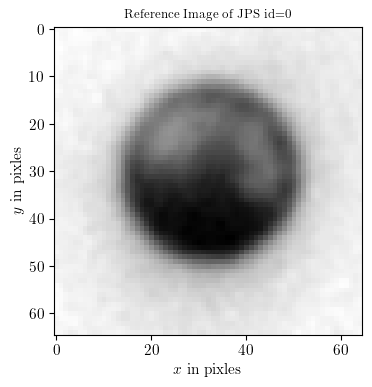

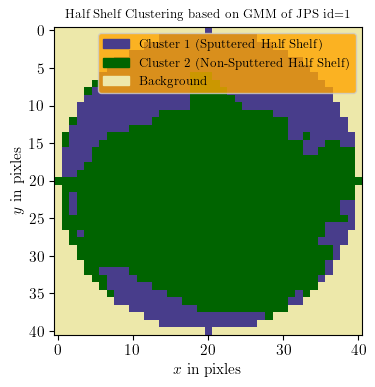

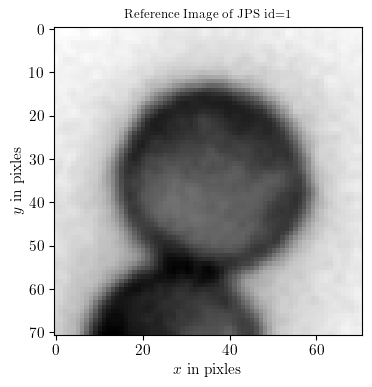

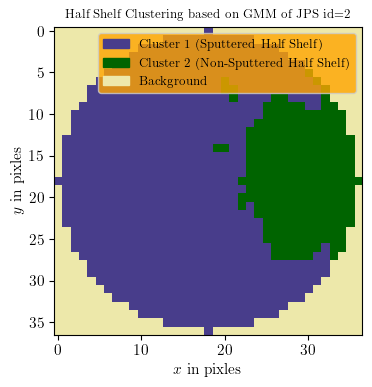

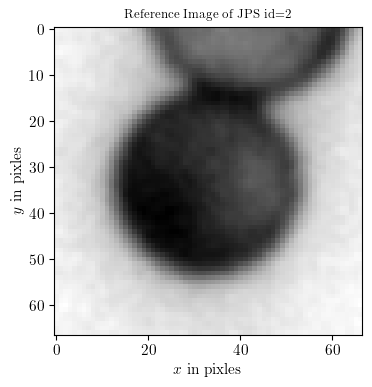

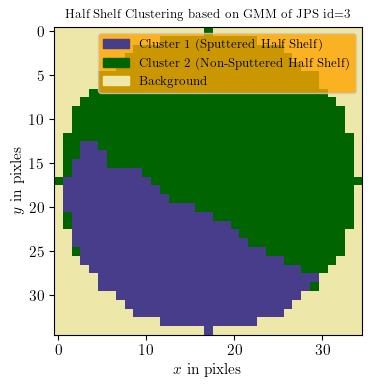

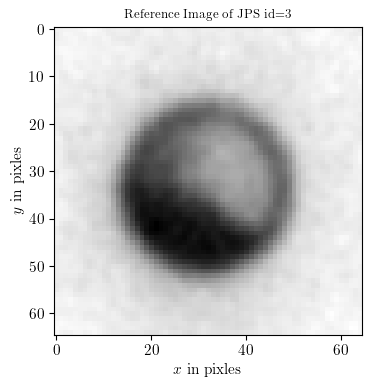

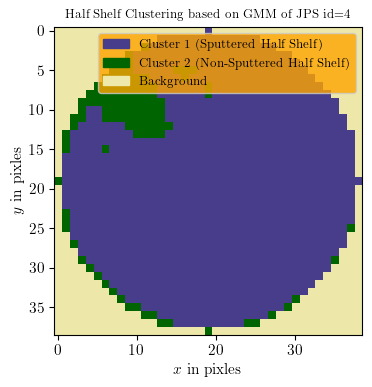

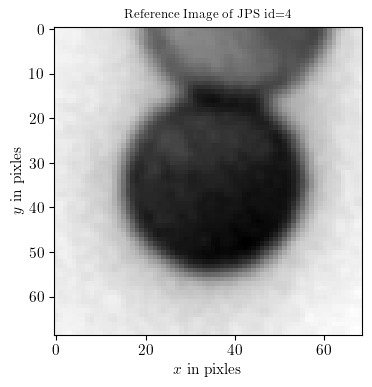

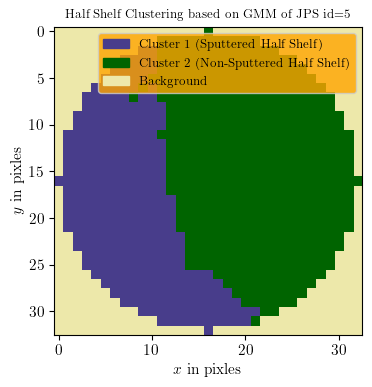

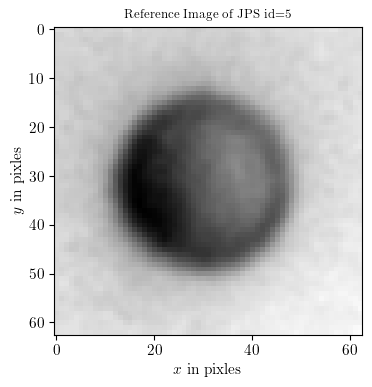

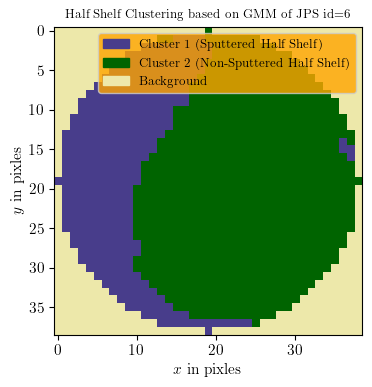

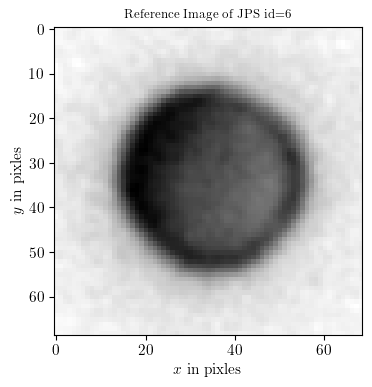

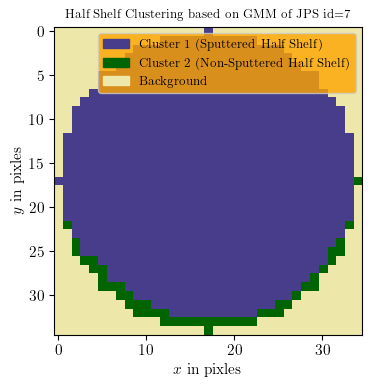

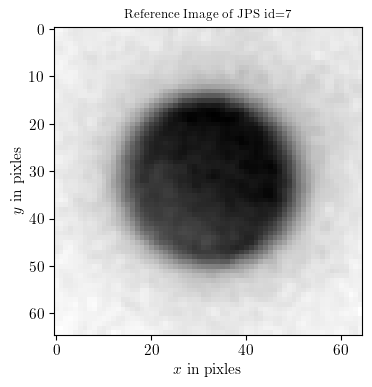

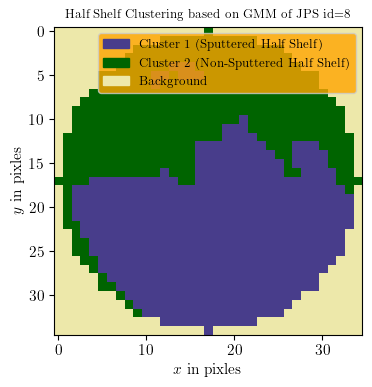

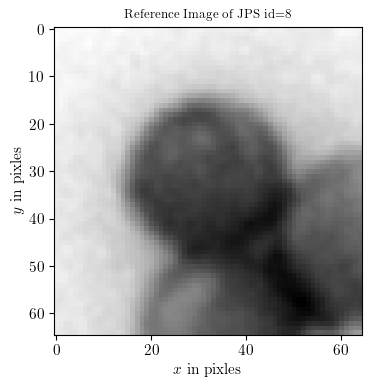

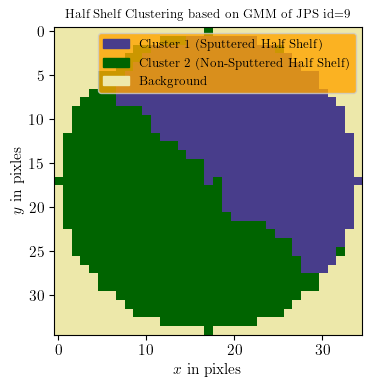

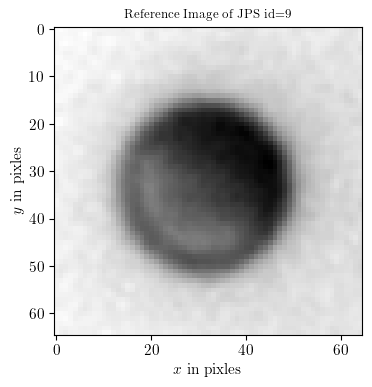

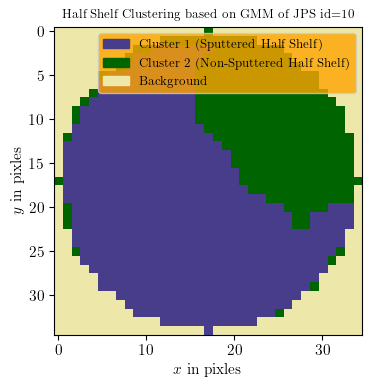

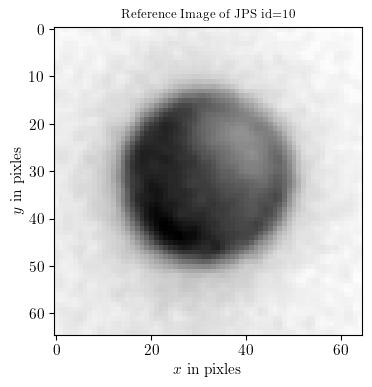

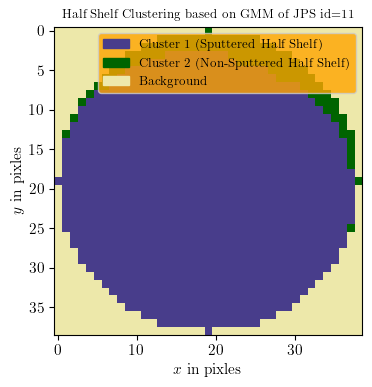

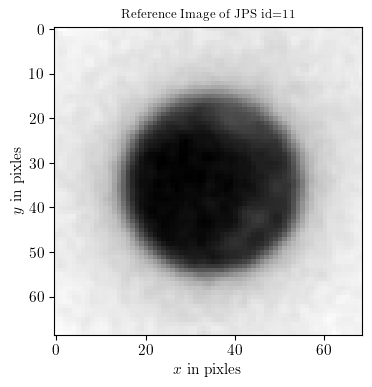

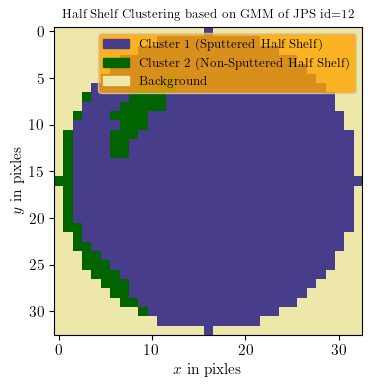

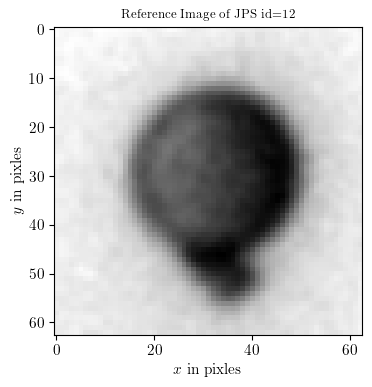

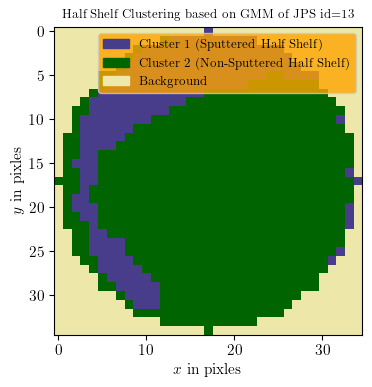

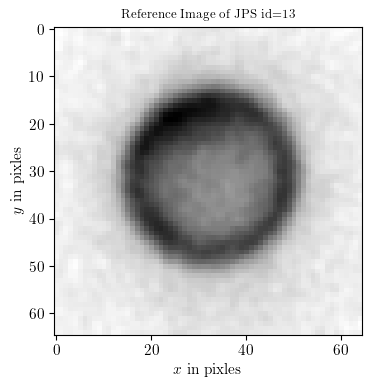

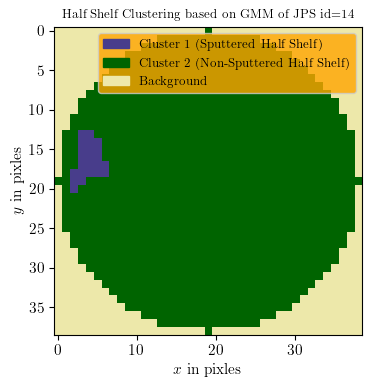

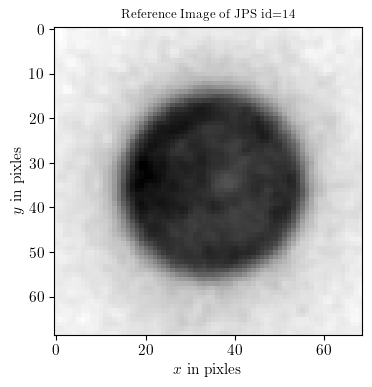

In [7]:
l=15
colors = [(0.933, 0.91, 0.667),'darkslateblue','darkgreen']
cmap = ListedColormap(colors)

for i in range(number_objs):
    a=objects_clustered[i].reshape((objects_clustered[i].shape[0],-1))
    b=np.sum(a,axis=1)
    #index=np.argsort(b)[len(b)//2]
    index=a.shape[0]//2

    frame_number=int(objs[i][index,0])
    y_center=round(objs[i][index,2])
    x_center=round(objs[i][index,1])
    r=cut_radius[i]+l
    I=np.load("../"+stream_string[frame_number])
    obj_im_test=cv.cvtColor(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:],cv.COLOR_BGR2GRAY)



    fig=plt.figure(figsize=(10, 4))
    plt.title("Half Shelf Clustering based on GMM of JPS id="+str(i),fontsize='small')
    plt.imshow(objects_clustered[i][index,:,:],cmap=cmap)
    plt.xlabel("$x$ in pixles")
    plt.ylabel("$y$ in pixles")
    ax=fig.gca()
    ax.set_rasterized(True)
    g1_patch = mpatches.Patch(color='darkslateblue', label='Cluster 1 (Sputtered Half Shelf)')
    g2_patch = mpatches.Patch(color='darkgreen', label='Cluster 2 (Non-Sputtered Half Shelf)')
    g3_patch = mpatches.Patch(color=(0.933, 0.91, 0.667), label='Background')
    plt.legend(handles=[g1_patch,g2_patch, g3_patch],frameon=True, facecolor="orange",fontsize='small')
    plt.show()
    #fig.savefig('../export_graphs/half_shelf_gmm_clustered'+str(i)+".eps", format="eps", dpi=1200, bbox_inches="tight")

    fig=plt.figure(figsize=(10, 4))
    plt.title("Reference Image of JPS id="+str(i),fontsize='small')
    plt.imshow(obj_im_test,cmap="grey")
    plt.xlabel("$x$ in pixles")
    plt.ylabel("$y$ in pixles")
    ax=fig.gca()
    ax.set_rasterized(True)
    plt.show()
    #fig.savefig('../export_graphs/half_shelf_gmm_clustered_reference'+str(i)+".eps", format="eps", dpi=1200, bbox_inches="tight")



In [8]:
# create videos

# set frames per second
fps=5


l=0
for k in range(len(objs)):
    i=0

    height=400
    width=400
    video = cv.VideoWriter(os.path.join("../Video_Data/Gute_aufnahme_shortened","obj_"+str(k)+".avi"), 0, fps, (height,width) ,isColor=False)
    for i in range(objects_clustered[k].shape[0]):
        frame_number=int(objs[k][i,0])
        y_center=round(objs[k][i,2])
        x_center=round(objs[k][i,1])
        I=np.load("../"+stream_string[frame_number])
        if i==0:
            flag_skip=True
        if flag_skip and 0==(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:].shape[0])*(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:]).shape[1]:
            continue
        else:
            flag_skip=False
        if 0==(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:].shape[0])*(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:]).shape[1]:
            break
        obj_im_test=cv.cvtColor(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:],cv.COLOR_BGR2GRAY)
        out=np.zeros_like(obj_im_test)
        out=cv.normalize(obj_im_test,out,alpha=255,beta=0,norm_type=cv.NORM_MINMAX, dtype=cv.CV_8UC1)
        out=cv.resize(out, (width,height), interpolation= cv.INTER_NEAREST)
        video.write(out.astype(np.uint8))
    cv.destroyAllWindows()
    video.release()

In [9]:
l=15
data=particle_datas_flat[11]
print(data.shape)
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import maximum_filter1d
from scipy.ndimage import minimum_filter1d
#data_out=minimum_filter1d(data, size=3,axis=0)
#data_out=maximum_filter1d(data, size=3,axis=0)
data_out=gaussian_filter1d(data, radius=1,axis=0,sigma=1)
out=structured_datas[11].expand_data(data_out)

out=np.pad(out,[(0,0),(l,l),(l,l)])
M=koppenrath.sell_cake(cut_radius[11],out.shape[1],out.shape[1])

print(out.shape)


(101, 1129)
(101, 69, 69)


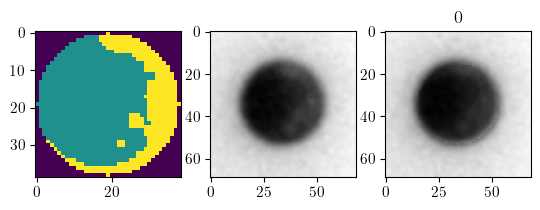

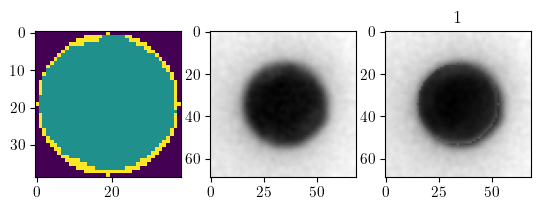

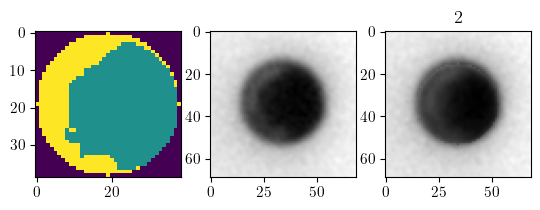

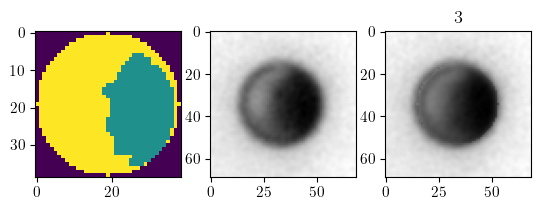

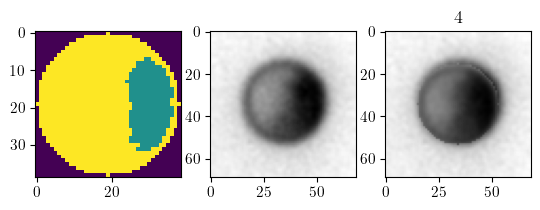

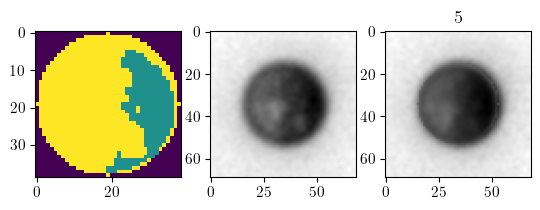

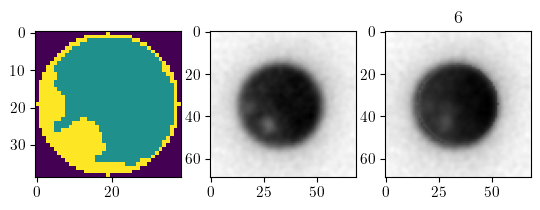

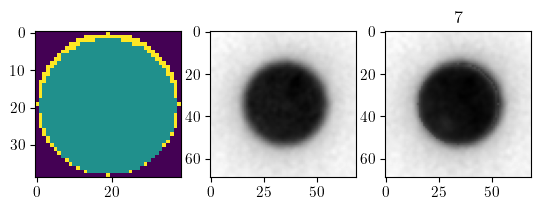

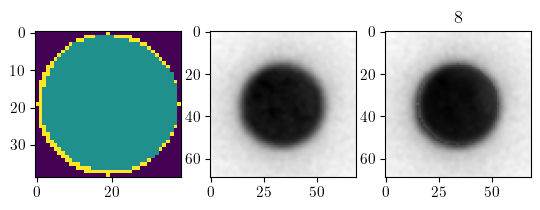

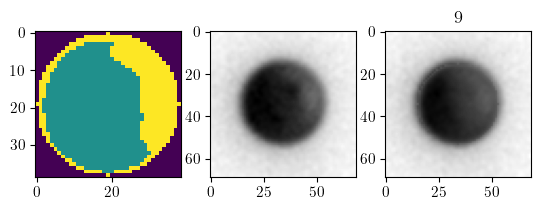

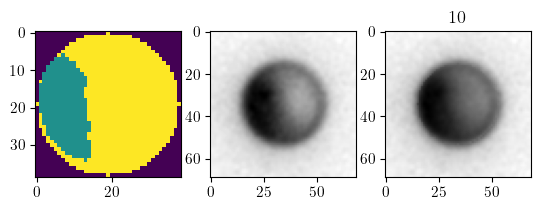

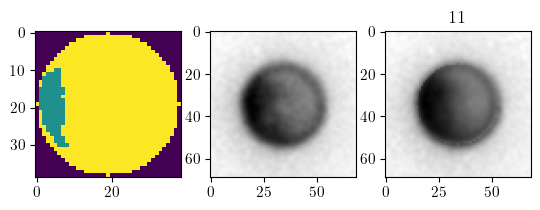

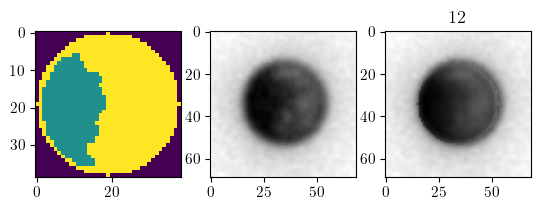

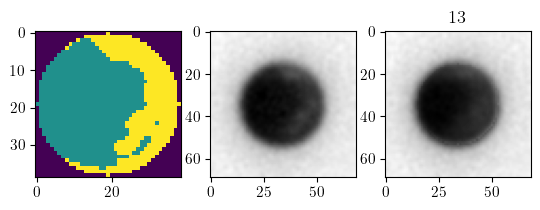

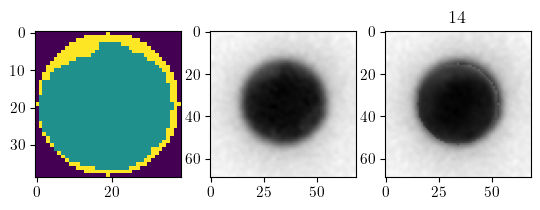

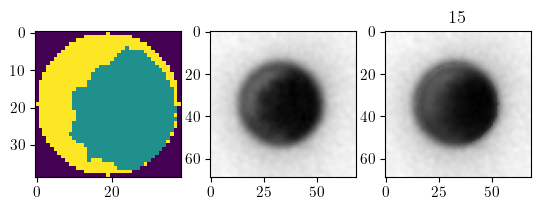

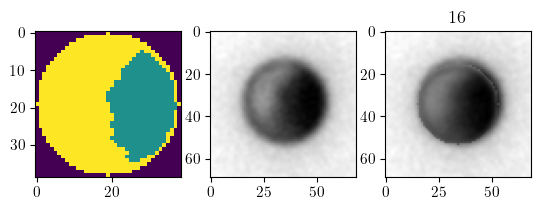

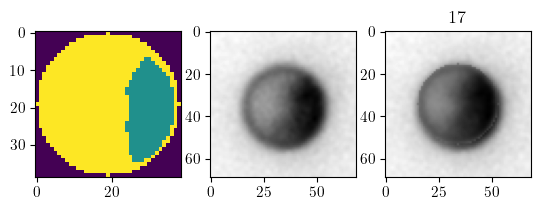

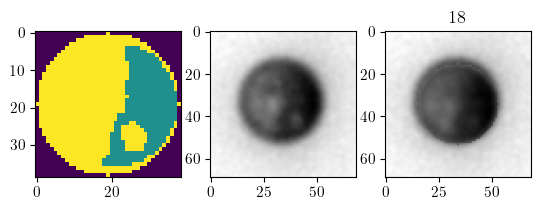

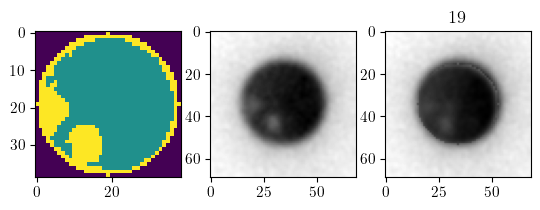

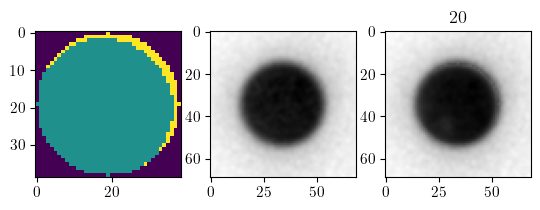

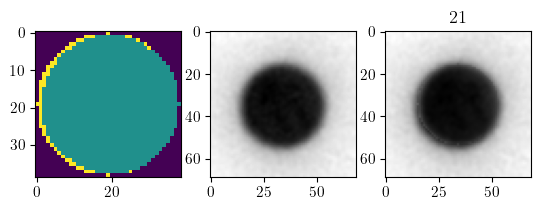

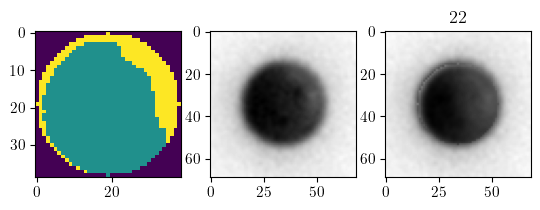

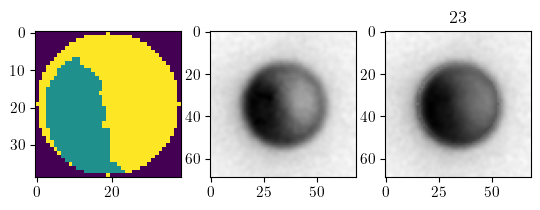

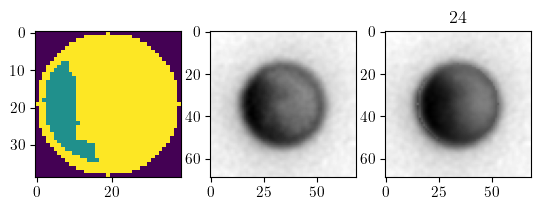

In [10]:
l=15
colors = ['darkslateblue', 'darkgreen']
k=11
for i in range(25):
    fig,ax=plt.subplots(1,3)
    ax[0].imshow(objects_clustered[k][i,:,:])
    frame_number=int(objs[k][i,0])
    y_center=round(objs[k][i,2])
    x_center=round(objs[k][i,1])
    r=cut_radius[k]+l
    I=np.load("../"+stream_string[frame_number])
    obj_im_test=cv.cvtColor(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:],cv.COLOR_BGR2GRAY)
    ax[1].imshow(obj_im_test,cmap="grey")
    obj_filter=np.copy(obj_im_test)
    obj_filter[M==1]=out[i,M==1]
    ax[2].imshow(obj_filter,cmap="grey")
    plt.title(str(i))
    plt.show()



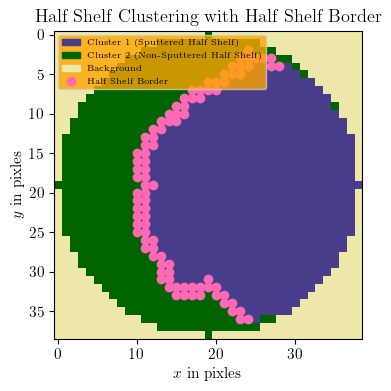

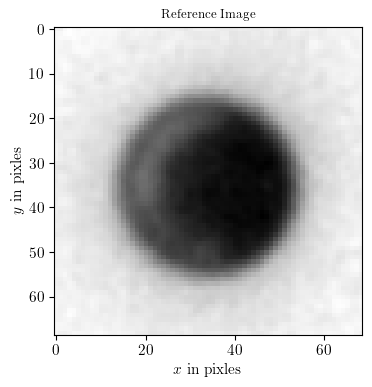

In [11]:
t=28

edge_object=contour_edge(objects_clustered[k], cut_radius=cut_radius[k], confectionery=koppenrath)
edge_object.compute_edges()
edge_object.reduce_edges()
edge_pixels=edge_object.edge_pixels



fig=plt.figure(figsize=(10, 4))
plt.title("Half Shelf Clustering with Half Shelf Border")
plt.imshow(objects_clustered[k][28,:,:],cmap=cmap)
g4_patch=plt.scatter(edge_pixels[28][:,0],edge_pixels[28][:,1],color = 'hotpink', label="Half Shelf Border")
plt.xlabel("$x$ in pixles")
plt.ylabel("$y$ in pixles")
ax=fig.gca()
g1_patch = mpatches.Patch(color='darkslateblue', label='Cluster 1 (Sputtered Half Shelf)')
g2_patch = mpatches.Patch(color='darkgreen', label='Cluster 2 (Non-Sputtered Half Shelf)')
g3_patch = mpatches.Patch(color=(0.933, 0.91, 0.667), label='Background')
plt.legend(handles=[g1_patch,g2_patch, g3_patch,g4_patch],frameon=True, facecolor="orange",fontsize='xx-small',loc="upper left")
plt.show()
ax.set_rasterized(True)
#fig.savefig('../export_graphs/half_shelf_gmm_border.eps', format="eps", dpi=1200, bbox_inches="tight")


y_center=round(objs[k][t,2])
x_center=round(objs[k][t,1])
r=cut_radius[k]+l
frame_number=round(objs[k][t,0])
I=np.load("../"+stream_string[frame_number])
obj_im_test=cv.cvtColor(I[y_center-r:y_center+r+1,x_center-r:x_center+r+1,:],cv.COLOR_BGR2GRAY)

fig=plt.figure(figsize=(10, 4))
plt.title("Reference Image",fontsize='small')
plt.imshow(obj_im_test,cmap="grey")
plt.xlabel("$x$ in pixles")
plt.ylabel("$y$ in pixles")
ax=fig.gca()
ax.set_rasterized(True)
plt.show()
#fig.savefig('../export_graphs/half_shelf_gmm_border_reference.eps', format="eps", dpi=1200, bbox_inches="tight")



In [12]:
edge_pixels_local_trajectory=[]
edge_object=contour_edge(objects_clustered[k], cut_radius=cut_radius[k], confectionery=koppenrath)
edge_object.compute_edges()
edge_object.reduce_edges()
edge_pixels=edge_object.edge_pixels
radius=round(np.mean(objs[k][:,-1]))
center=np.array([radius,radius]).reshape((1,2))
for i in range(particle_datas_3d[k].shape[0]):
    edge_pixels_local=edge_pixels[i][:,:-1]-center
    z=-np.sqrt(radius**2-np.sum(edge_pixels_local**2,axis=1).reshape((-1,1)))
    edge_pixels_3d_local=np.concatenate((edge_pixels_local,z),axis=1)
    edge_pixels_local_trajectory.append(edge_pixels_3d_local)


In [13]:
n_1,_=caluclate_normal_vector_from_contour(edge_pixels_local_trajectory[t])
n_1=orient_normal_plane(n_1, objects_clustered[k][t,:,:], objs[k], t)

attention=attention_edge_pixel(edge_pixels_local_trajectory[t],cut_radius[k])
n_2,_=caluclate_normal_vector_from_contour(edge_pixels_local_trajectory[t]*np.sqrt(attention[:,np.newaxis]))
n_2=orient_normal_plane(n_2, objects_clustered[k][t,:,:], objs[k], t)

# Draw ellipse

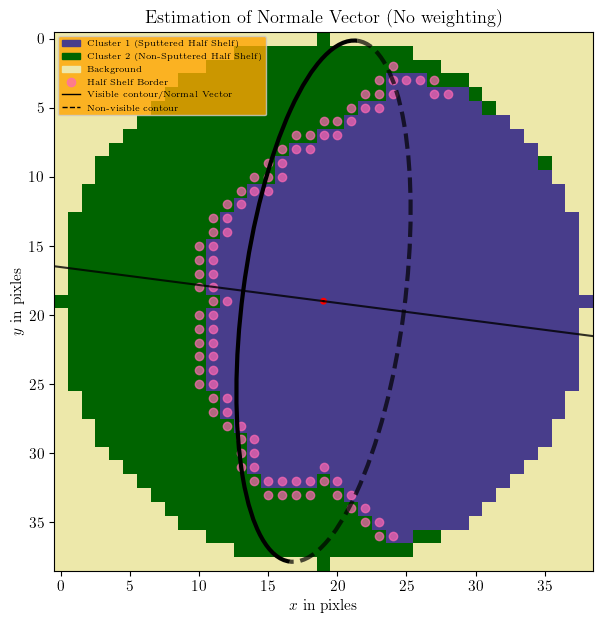

In [15]:
n=n_1

fig=plt.figure(figsize=(10, 7))
plt.title("Estimation of Normale Vector (No weighting)")
im=objects_clustered[k][28,:,:]



# Define ellipse parameters
center = (im.shape[1]//2, im.shape[0]//2)  # Center of the ellipse
width,height,angle,up_down=calculate_ellipse(n,cut_radius[k])

#Create the ellipse patch
if up_down:
    ellipse_patch_1 = Arc(center, width, height, angle=angle, theta1=0, theta2=180,fill=False, edgecolor='black',linewidth=3)
    ellipse_patch_2 = Arc(center, width, height, angle=angle, theta1=180, theta2=360,fill=False, edgecolor='black',linewidth=3,linestyle="--",alpha=0.7)
else:
    ellipse_patch_1 = Arc(center, width, height, angle=angle, theta1=180, theta2=360,fill=False, edgecolor='black',linewidth=3)
    ellipse_patch_2 = Arc(center, width, height, angle=angle, theta1=0, theta2=180,fill=False, edgecolor='black',linewidth=3,linestyle="--",alpha=0.7)
circle_patch = plt.Circle(center, 0.2, color='red', fill=True)
e1=(n[:2]/n[0])*(cut_radius[k]+0.5)

# Add the ellipse patch to the subplot


plt.imshow(im,cmap=cmap)
g4_patch=plt.scatter(edge_pixels[28][:,0],edge_pixels[28][:,1],color = 'hotpink', label="Half Shelf Border",alpha=0.7)
plt.xlabel("$x$ in pixles")
plt.ylabel("$y$ in pixles")

ax=fig.gca()
g1_patch = mpatches.Patch(color='darkslateblue', label='Cluster 1 (Sputtered Half Shelf)')
g2_patch = mpatches.Patch(color='darkgreen', label='Cluster 2 (Non-Sputtered Half Shelf)')
g3_patch = mpatches.Patch(color=(0.933, 0.91, 0.667), label='Background')
g5_patch = Line2D([0], [0], color='black', lw=1, label='Visible contour/Normal Vector')
g6_patch = Line2D([0], [0], color='black', lw=1, linestyle='dashed', label="Non-visible contour")

ax.add_patch(ellipse_patch_1)
ax.add_patch(ellipse_patch_2)
ax.add_patch(circle_patch)
ax.add_line(g5_patch)

ax.plot([0+center[0], e1[0]+center[0]], [0+center[0], e1[1]+center[0]], color='black',linewidth=1.5,label="Non visible contour",alpha=0.8)
ax.plot([0+center[0], -e1[0]+center[0]], [0+center[0], -e1[1]+center[0]], color='black',linewidth=1.5, label="Visible contour",alpha=0.8)

# Show plot#
plt.legend(handles=[g1_patch,g2_patch, g3_patch,g4_patch,g5_patch, g6_patch],frameon=True, facecolor="orange",fontsize='xx-small',loc="upper left")

plt.show()
ax.set_rasterized(True)

fig.savefig('../export_graphs/half_shelf_gmm_ellipse_no_weight.eps', format="eps", dpi=1200, bbox_inches="tight")

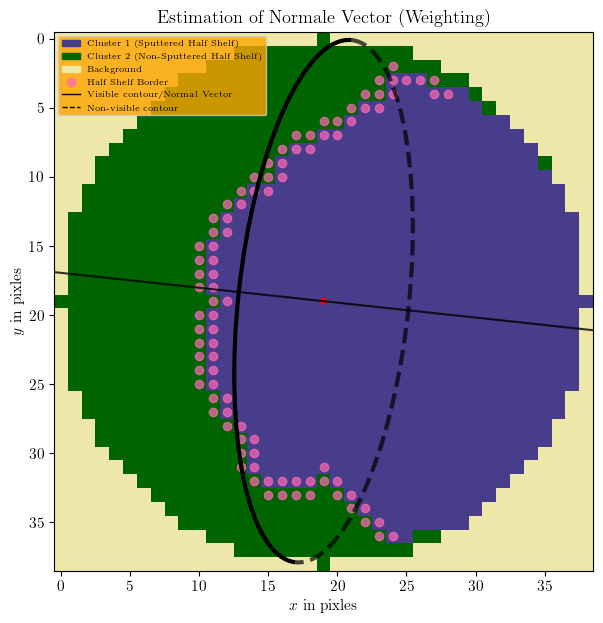

In [16]:
n=n_2

fig=plt.figure(figsize=(10, 7))
plt.title("Estimation of Normale Vector (Weighting)")
im=objects_clustered[k][28,:,:]



# Define ellipse parameters
center = (im.shape[1]//2, im.shape[0]//2)  # Center of the ellipse
width,height,angle,up_down=calculate_ellipse(n,cut_radius[k])

#Create the ellipse patch
if up_down:
    ellipse_patch_1 = Arc(center, width, height, angle=angle, theta1=0, theta2=180,fill=False, edgecolor='black',linewidth=3)
    ellipse_patch_2 = Arc(center, width, height, angle=angle, theta1=180, theta2=360,fill=False, edgecolor='black',linewidth=3,linestyle="--",alpha=0.7)
else:
    ellipse_patch_2 = Arc(center, width, height, angle=angle, theta1=0, theta2=180,fill=False, edgecolor='black',linewidth=3)
    ellipse_patch_1 = Arc(center, width, height, angle=angle, theta1=180, theta2=360,fill=False, edgecolor='black',linewidth=3,linestyle="--",alpha=0.7)
circle_patch = plt.Circle(center, 0.2, color='red', fill=True)
e1=(n[:2]/n[0])*(cut_radius[k]+0.5)

# Add the ellipse patch to the subplot


plt.imshow(im,cmap=cmap)
g4_patch=plt.scatter(edge_pixels[28][:,0],edge_pixels[28][:,1],color = 'hotpink', label="Half Shelf Border",alpha=0.7)
plt.xlabel("$x$ in pixles")
plt.ylabel("$y$ in pixles")

ax=fig.gca()
g1_patch = mpatches.Patch(color='darkslateblue', label='Cluster 1 (Sputtered Half Shelf)')
g2_patch = mpatches.Patch(color='darkgreen', label='Cluster 2 (Non-Sputtered Half Shelf)')
g3_patch = mpatches.Patch(color=(0.933, 0.91, 0.667), label='Background')
g5_patch = Line2D([0], [0], color='black', lw=1, label='Visible contour/Normal Vector')
g6_patch = Line2D([0], [0], color='black', lw=1, linestyle='dashed', label="Non-visible contour")

ax.add_patch(ellipse_patch_1)
ax.add_patch(ellipse_patch_2)
ax.add_patch(circle_patch)
ax.add_line(g5_patch)

ax.plot([0+center[0], e1[0]+center[0]], [0+center[0], e1[1]+center[0]], color='black',linewidth=1.5,label="Non visible contour",alpha=0.8)
ax.plot([0+center[0], -e1[0]+center[0]], [0+center[0], -e1[1]+center[0]], color='black',linewidth=1.5, label="Visible contour",alpha=0.8)

# Show plot#
plt.legend(handles=[g1_patch,g2_patch, g3_patch,g4_patch,g5_patch, g6_patch],frameon=True, facecolor="orange",fontsize='xx-small',loc="upper left")

plt.show()
ax.set_rasterized(True)

fig.savefig('../export_graphs/half_shelf_gmm_ellipse_weight.eps', format="eps", dpi=1200, bbox_inches="tight")
